# De Novo Generation of Bitter Molecules

In this webinar, we train a [Hidden Markov Model](https://en.wikipedia.org/wiki/Hidden_Markov_model) on a large corpus of SMILES strings, and use it to generate new SMILES strings. Finally, taking things one step further, we combine our newly-trained generative model with the bitterness classifier trained in the previous webinar. The end result of this generate->filter approach is a pipeline that generates new possibly-bitter molecules.

In [1]:
!pip install optuna rdkit_pypi deepchem transformers matplotlib tqdm hmmlearn xgboost

In [3]:
import os
from typing import List
import random
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rdkit.Chem.Descriptors
from hmmlearn.hmm import MultinomialHMM
import xgboost

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski, Descriptors
import functools

# Read in our corpus of SMILES strings

We have acquired a large datase of SMILES strings from the following repository: https://github.com/GLambard/Molecules_Dataset_Collection

We'll git clone, iterate over each file, and read in all of the SMILES strings we can find. In addition, for the purposes of keeping things simple in the webinar, we'll remove SMILES strings containing a colon (used for denoting the conjugated pi-bonds present in aromatic systems). This makes the problem a bit easier for our model to learn.

In [3]:
!git clone https://github.com/Exabyte-io/Molecules_Dataset_Collection.git ../assets/Molecules_Dataset_Collection

Cloning into '../assets/Molecules_Dataset_Collection'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63
Receiving objects: 100% (63/63), 62.08 MiB | 6.80 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [4]:
dataset_path = '../assets/Molecules_Dataset_Collection/latest'
files = [i for i in os.listdir(dataset_path) if i.endswith('csv')]

all_smiles = set()

for file in files:
    df = pd.read_csv(os.path.join(dataset_path,file))
    all_smiles.update(df.smiles.dropna())
    
all_smiles = set(smile for smile in all_smiles if ':' not in smile)
print(f"total of {len(all_smiles)} smiles")
print("Sample smiles:")
for count,smile in enumerate(all_smiles):
    print(smile)
    if count > 10:
        break

total of 10610 smiles
Sample smiles:
[Ag+].[C-]#N.[C-]#N.[K+]
C[N+]1(C)COC(=S)S[Fe-4]123(SC(=S)OC[N+]2(C)C)SC(=S)OC[N+]3(C)C
COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N4CCN(C)CC4)C3=O)N1CC1NC12
CC1=C(C)C(=O)C(CCCCC#CCCCC#CCO)=C(C)C1=O
CC(Cl)C(Cl)Cl
C=CCNC(=O)C=CC(=O)O
CCCCCCCCCCCC[N+](C)(C)C.[Br-]
N#C[N-]C#N.[Na+]
CC(C)CC(C#N)C(=O)O
CCCCOC1NC(=O)NC(=O)C1(F)C(=O)OCC
Cl.NCCO/C=C/[C@H](N)C(=O)O
O=C(O)C1CC(C(=O)O)SS1


# Import the SMILES Tokenizer from DeepChem

Next, we'll take advantage of the work of DeepChem, an open-source machine learning library focused on science. One of the tools that DeepChem provides is a SMILES tokenizer. This is used to convert a SMILES string into a list of individual pieces, or "tokens." For example, a single carbon atom may be a token, an opening parenthesis may be a token, etc. This is slightly different than simply separating by character, as tokens are allowed to contain multiple characters (e.g. \[Na+\] may be a token).

In [5]:
# Need to patch deepchem first per https://github.com/deepchem/deepchem/issues/2519
import re, importlib
deepchem_root_path=importlib.util.find_spec('deepchem').origin
smiles_tokenizer_path = os.path.join(os.path.dirname(deepchem_root_path), "feat", "smiles_tokenizer.py")
with open(smiles_tokenizer_path, "r") as inp:
    file_contents = inp.read()
with open(smiles_tokenizer_path, "w") as outp:
    for line in file_contents.split("\n"):
        outp.write(re.sub("max_len(\s|$)", "model_max_length", line) + "\n")
    
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

# Tokenize the Strings

The other important feature of the SMILES tokenizer is that it can also encode our tokenized SMILES strings. After we have tokenized our strings, we need to convert the individual tokens into numbers (for example, we may replace "C" with a "10" every time we see it, a "(" may become a "2", etc) for our ML algorithm to be able to use it. This process of taking a list of tokens, and mapping the strings to integers, is called "encoding."

In [6]:
class SmilesEncoder():
    def __init__(self):
        # Download Deepchem's vocabulary file if we don't already have it
        vocab_url = "https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/tests/data/vocab.txt"
        self.vocab_path = "../assets/deepchem_smiles_vocab.txt"
        if not os.path.exists(self.vocab_path):
            with open(vocab_path, "wb") as outp:
                download = urllib.request.urlopen(vocab_url)
                outp.write(download.read())
                
                # Also, make sure colons are in our vocabulary
                outp.write(b"\n:")
                
        self.tokenizer = SmilesTokenizer(self.vocab_path)
        self.inversion_dict = {value:key for key,value in self.tokenizer.vocab.items()}
        
        self.ignored_range = list(range(self.tokenizer.vocab['[PAD]'], self.tokenizer.vocab['[MASK]']))
        
    def transform(self, X:str) -> List[int]:
        # Don't care about the start/end
        tokenized = self.tokenizer.encode(X)
        return tokenized
    
    def inverse_transform(self, X:List[int]) -> str:
        sep = self.tokenizer.vocab['[SEP]']
        if sep in X:
            end_index = np.random.choice(np.where(X==sep)[0])
            if end_index <= 1:
                end_index = -1
        else:
            end_index = -1
        result = "".join(self.inversion_dict[i] for i in X[1:end_index] if i not in self.ignored_range)
        return result   
enc = SmilesEncoder()

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [7]:
encoded = list(map(enc.transform, all_smiles))
np.random.shuffle(encoded)

# Tune the Hidden Markov Model

As a first-order guess, we'll check a few number of hidden states for the Hidden Markov Model (HMM). We just do a gridsearch over models with 1-4 hidden states, and record the average log likelihood of the model when trained on a random subsample of the data. We train on a random subsample instead of the full dataset here primarily as a convenience for the purposes of demonstration, because the model may take a while to train as the dataset grows larger. To help get a better idea of the error, we repeat this process of randomly subsampling, training, and assessing with log-likelihood several times.

In [8]:
# Here, we're just going to use grid search, assesing the model accuracy via random subsampling from the dataset

def objective(n_states: int) -> int:
    """
    Optimize the number of hidden states. Train on a random subsample from the dataset, since this is rather expensive to run.
    """
    n_subsamples = 16
    subsample_size = 128
    
    total = 0
    for n in tqdm.trange(n_subsamples):
        model = MultinomialHMM(n_states, verbose=False, n_iter=64)
        x=np.concatenate([random.choice(encoded) for _ in range(subsample_size)]).reshape(-1,1)
        model.fit(x)
        total += model.score(x)
    mean = total / n_subsamples
    return mean

vals = []
n_max = 4
for n in range(1,n_max+1):
    print(f"{n} states", flush=True)
    vals.append(objective(n))

1 states


100%|██████████| 16/16 [00:00<00:00, 20.94it/s]

2 states



100%|██████████| 16/16 [00:17<00:00,  1.09s/it]

3 states



100%|██████████| 16/16 [00:21<00:00,  1.35s/it]

4 states



100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


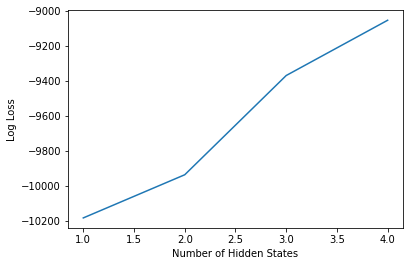

In [9]:
plt.plot(list(range(1,len(vals)+1)), vals)
plt.xlabel("Number of Hidden States")
plt.ylabel("Log Loss")
plt.show()
plt.close()

# Train the Hidden Markov Model

Next, we'll take whichever number of hidden states made a model with the best log-likelihood. As we might expect, a more-complex HMM (more hidden states) captures the data a bit better - so we select 4 states.

Next, we'll train the model on the full dataset, until the error is either below 0.01 (the default in HMMlearn), or 1024 training steps have run.

In [10]:
best_n, best_loss = max(enumerate(vals, 1), key=lambda i: i[0])
print(f"Training with {best_n} hidden states")

model = MultinomialHMM(best_n, verbose=True, n_iter=1024)

# This is still a fairly expensive model to train, so we'll restrict ourselves to 10000 molecules in the dataset
model.fit(np.concatenate(encoded).reshape(-1,1))

Training with 4 hidden states


         1    -2395793.9332             +nan
         2     -849767.0312    +1546026.9020
         3     -849556.5577        +210.4735
         4     -849312.5025        +244.0552
         5     -849005.9867        +306.5158
         6     -848600.1924        +405.7943
         7     -848045.6057        +554.5867
         8     -847275.4324        +770.1733
         9     -846201.5457       +1073.8867
        10     -844708.3594       +1493.1864
        11     -842634.0357       +2074.3237
        12     -839727.6054       +2906.4303
        13     -835619.0173       +4108.5881
        14     -829969.7729       +5649.2444
        15     -822988.3136       +6981.4593
        16     -815785.0989       +7203.2147
        17     -809509.0484       +6276.0505
        18     -804373.6156       +5135.4328
        19     -800128.6238       +4244.9918
        20     -796671.0279       +3457.5959
        21     -793972.2434       +2698.7844
        22     -791899.8029       +2072.4405
        23

MultinomialHMM(n_components=4, n_iter=1024,
               random_state=RandomState(MT19937) at 0x1134CDC40, verbose=True)

In [16]:
# Now that we have the model, let's save it to disk (just in case)
import pickle
with open("../assets/smiles_markov_model.pkl", "wb") as outp:
    pickle.dump(model, outp)

# Create a Molecule Pipeline

We'll then wrap our HMM into a generator function. This is an initial filter we place over the model, giving users the ability to filter generated models by the number of atoms.

In [12]:
def generate_molecules(min_heavy_atoms:int, max_heavy_atoms:int, num_mols:int, verbose:bool=True) -> List[rdkit.Chem.Mol]:
    """
    A pipeline that generates our molecules, from our generator!
    """
    pred_mols = []
    while len(pred_mols) < num_mols:
        sample, _ = model.sample(max_heavy_atoms)
        sample = sample.T[0]
        pred = enc.inverse_transform(sample)

        try:
            mol = rdkit.Chem.MolFromSmiles(pred)
        except:
            mol = None
        if mol and mol.GetNumAtoms() >= min_heavy_atoms:
            pred_mols.append(mol)
            if verbose:
                print(f"Found {len(pred_mols)} molecules. New molecule has weight {np.round((rdkit.Chem.Descriptors.MolWt(mol)),3)} amu")
    return pred_mols

Found 1 molecules. New molecule has weight 60.096 amu
Found 2 molecules. New molecule has weight 72.151 amu
Found 3 molecules. New molecule has weight 60.052 amu
Found 4 molecules. New molecule has weight 78.051 amu
Found 5 molecules. New molecule has weight 56.088 amu
Found 6 molecules. New molecule has weight 141.239 amu
Found 7 molecules. New molecule has weight 205.298 amu
Found 8 molecules. New molecule has weight 115.156 amu


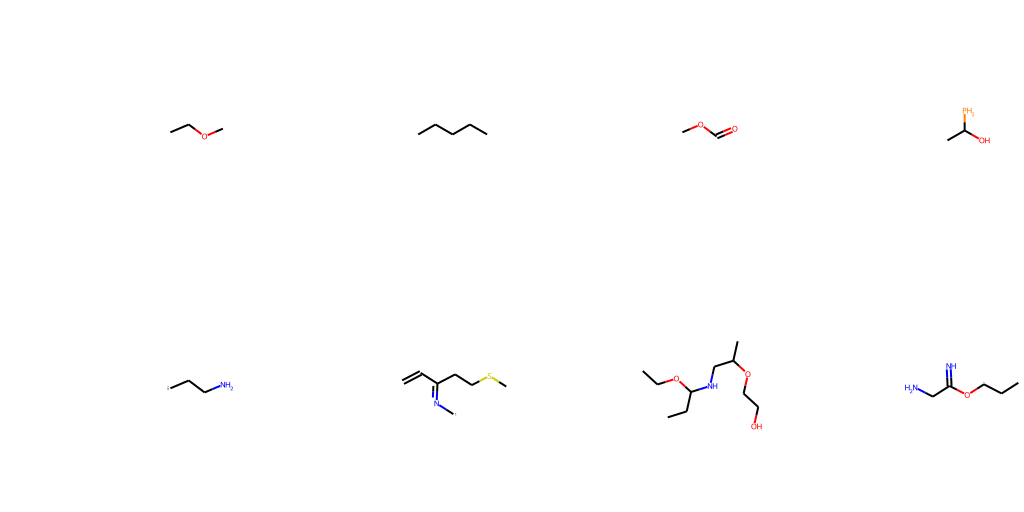

In [19]:
molecules = generate_molecules(min_heavy_atoms=4, max_heavy_atoms=64, num_mols=8, verbose=True)
img = rdkit.Chem.Draw.MolsToGridImage(molecules, subImgSize=[256,256], molsPerRow=4)
img

# Screen for Bitterness

Finally, we'll add one more filter to our model. Now that we have a set of knobs to turn for the molecule's complexity (number of atoms), we'll also add a filter for bitterness. Taking advantage of our trained model from the last webinar, we'll repeatedly generate models swith the generator, continuing until we have some user-defined set of potentially-bitter molecules.

In [20]:
with open("../assets/bittersweet_xgboost.pkl", "rb") as inp:
    pipeline = pickle.load(inp)
    
# Create a function to do the featurization and prediction
def predict_bitter_from_smiles(mol, model=pipeline):
    # The XGBoost classifier we trained in the last webinar takes in these features in this exact order
    descriptors = (Lipinski.NumAromaticRings,
                   Lipinski.NumHAcceptors,
                   Lipinski.NumHDonors,
                   Descriptors.MolWt,
                   Descriptors.MinPartialCharge,
                   Descriptors.MaxPartialCharge,
                   Descriptors.FpDensityMorgan1,
                   Descriptors.FpDensityMorgan2,
                   Descriptors.FpDensityMorgan3,
                  )
    
    features = [descriptor(mol) for descriptor in descriptors]
    result = model.predict([features])
    return result

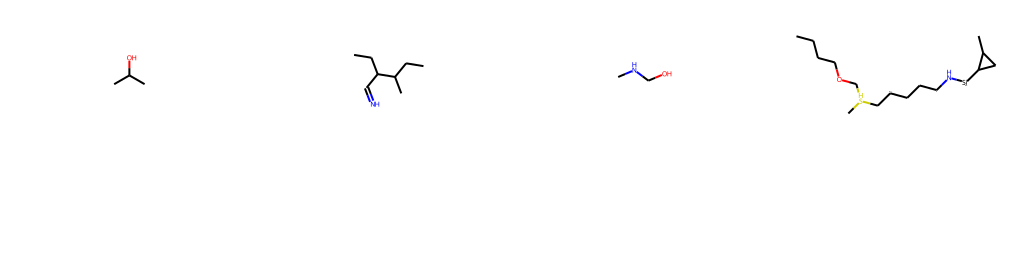

In [32]:
bitter_candidates = []
n_desired_candidates = 4
while len(bitter_candidates) < n_desired_candidates:
    bitter_candidates += list(filter(predict_bitter_from_smiles, generate_molecules(min_heavy_atoms=4,
                                                          max_heavy_atoms=30,
                                                          num_mols=16,
                                                          verbose=False)
          ))
img = rdkit.Chem.Draw.MolsToGridImage(bitter_candidates[:n_desired_candidates], subImgSize=[256,256], molsPerRow=4)
img

Of interest is that the pipeline generated a molecule that does indeed have a bitter taste. The first molecule in the above image is 2-propanol, which has a slightly bitter taste (per the MSDS as https://www2.atmos.umd.edu/~russ/MSDS/isopropanol_fisher.html). 